In [182]:
# 数据处理
import pandas as pd
import numpy as np
import json
import csv
import random
import math


# 网络分析与可视化
import networkx as nx
from pyvis import network as net
import matplotlib.pyplot as plt

## Functions

In [410]:

## 抽取关联网络
def Extract_Association_Network(df, entity_col, association_col, strength_thres):
    Source = []
    Target = []
    Strength = []
    
    entities = list(df[entity_col].unique())
    
    for i in range(len(entities)):
        for j in range(1, (len(entities) - i)):
            listA = list(df[df[entity_col]==entities[i]][association_col].unique())
            listB = list(df[df[entity_col]==entities[i+j]][association_col].unique())
            strength = len(set(listA)&set(listB))
            if strength > strength_thres:
                #print(features[i],features[i+j],features)
                Source.append(entities[i])
                Target.append(entities[i+j])
                Strength.append(strength)
                
    data_AssociationNetwork = {'Source': Source, 'Target': Target, 'Strength': Strength}
    df_AssociationNetwork = pd.DataFrame(data = data_AssociationNetwork)
    return df_AssociationNetwork



## 查找概念间共有的语义特征
def Extract_Associate_SemanticFeature(df, entity_col, association_col, concept_A, concept_B):
    listA = list(df[df[entity_col]==concept_A][association_col].unique())
    listB = list(df[df[entity_col]==concept_B][association_col].unique())
    return set(listA)&set(listB)



# 搜索出概念对应的所有语义特征及其激活状态，并按照 线索度cue_validity 排序 
def List_Semantic_Feature(df, concept):
    return df[df['Concept']==concept].sort_values(by=['cue_validity', 'activation'],ascending=False)[['Feature','cue_validity','activation']]



## 随机采样，模拟受损的个人语义网络
def Sample_PWA(df, sample_rate, mark_col):
    np.random.seed(10)
    remove_n = round(len(df)*sample_rate)
    drop_indices = np.random.choice(df.index, remove_n, replace=False)
    
    df_sample = df.copy()
    df_sample[mark_col] = 0
    for row in df_sample.iterrows():
        if row[0] in drop_indices:
            df_sample.loc[row[0],mark_col] = 1
        else:
            pass

    return df_sample[df_sample[mark_col]==1]



## 将 CSV 转成 Json 文件
# 为了适应NodeTrix/G6等不同库的数据格式需求，设置两个参数
# link_object_name: "links" / "edges" 
# node_content_mode: "index" / "name"



def Node_Link_CSV2Json(df_link, df_node, node_name_col, node_group_col, link_object_name, node_content_mode):  
    data = {
        "nodes": [],
        link_object_name: []
    }
    groups = []

    nodes = list(set(list(df_link.Source)+list(df_link.Target)))
    for node in nodes: 
        df_selected_node = df_node[df_node[node_name_col]==node]
        group = list(df_selected_node[node_group_col])[0]
        if group not in groups:
            groups.append(group)
        new_node = {        
            "id":list(df_selected_node[node_name_col])[0],
            "group":groups.index(group)
        } 
        if new_node not in data['nodes']:
            data['nodes'].append(new_node)

    for row in df_link.iterrows():
        if node_content_mode == "index":
            new_link = {
                "source":nodes.index(row[1]['Source']),
                "target":nodes.index(row[1]['Target']),
                "value":int(row[1]['Strength'])
            }
        elif node_content_mode == "name":
            new_link = {
                "source":row[1]['Source'],
                "target":row[1]['Target'],
                "value":int(row[1]['Strength'])
            }
            
        if new_link not in data[link_object_name]:
            data[link_object_name].append(new_link)
            
    print("nodes: "+str(len(data['nodes'])))
    print("links: "+str(len(data[link_object_name])))
            
    return data



# 两个值域区间映射
def translate(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)


# def searchCategory(df, superiorCategory, subCategory, keyword):
#     df_category = df[df['上级类别']==superiorCategory]

#     if superiorCategory == '':
#         return '上级类别有：'+str(df['上级类别'].unique().tolist())
#     else:
#         if subCategory == '':
#             df_category = df[df['上级类别']==superiorCategory]
#             return str(superiorCategory) + '中的下级类别有：' + str(df_category['下级类别'].unique().tolist())
#         else:
#             if keyword == '':
#                 df_category = df[df['上级类别']==superiorCategory]
#                 df_subcategory = df_category[df_category['下级类别']==subCategory]
#                 print(str(superiorCategory)+'-'+str(subCategory) + '中的概念数量为：'+str(len(df_subcategory)))
#                 return df_subcategory
#             else:
#                 df_category = df[df['上级类别']==superiorCategory]
#                 df_subcategory = df_category[df_category['下级类别']==subCategory]
#                 for row in df_subcategory.iterrows():
#                     features = df_features[df_features['概念']==row[1]['概念']].特征.tolist()
#                     feature_str = ','.join(features)
#                     if keyword in feature_str:
#                         print(row[1]['概念'])



def get_children(df, row_name):
    classes = set()
    for i, row in df.iterrows():
        classes.add(row[row_name])
    return classes

## 完整数据（概念-特征网络 / 概念关联网络 / 特征关联网络）

In [246]:
## 导入完整的概念-特征网络

# 导入concept-feature 连接数据
df_rel_raw = pd.read_csv('00_Raw Data/All concepts and features.csv')

# 导入concept 节点属性数据
df_concept_info = pd.read_csv('00_Raw Data/CCFD_concept_info.csv')

# join 成一张表
df_complete = df_rel_raw.join(df_concept_info.set_index('Id'), on='Concept').drop(["Unnamed: 4", "Label", "concept", "superior category", "subcategory"], axis=1)
df_complete.to_csv('01_Processed Data/Complete-Data.csv',index=False)

# # 读取已经处理好的完整语义网络数据
# df_complete = pd.read_csv('01_Processed Data/Complete-Data.csv')
# df_complete.head()

In [868]:
df_ = df_complete[['Concept', 'Feature', 'Frequency']]
df_.head(50)

,Concept,Feature,Frequency
0,安全带,可以-保护,27.096774
1,安全带,是-带子,22.258065
2,安全带,其他-车,17.419355
3,安全带,是-安保的,16.451613
4,安全带,可以-保护人,15.483871
5,安全带,需要-系,13.548387
6,安全带,像-绳子,8.709677
7,安全带,有-扣,8.709677
8,安全带,是-长的,6.774194
9,安全带,可以-固定,5.806452


In [636]:
# get_children(df_concept_info, '上级类别')
# df_concept_info[df_concept_info['上级类别']=='交通工具']

In [633]:
# 从完整数据中抽取概念层级树

root = {
    "id": "root",
    "children": []
}

for i in get_children(df_concept_info, '上级类别'):
    data_subclass = df_concept_info[df_concept_info['上级类别']==i]
    class_dic = {
        "id": i,
        "value":len(data_subclass),
        "children": []
    }
    root['children'].append(class_dic)
    
    for j in get_children(data_subclass,'下级类别'):
        if j not in get_children(df_concept_info, '上级类别'):
            data_word = data_subclass[data_subclass['下级类别']==j]
            subclass_dic = {
                "id": j,
                "value": len(data_word),
                # "children": []
            }
            class_dic['children'].append(subclass_dic)
        
        # for k in get_children(data_word,'word'):
        #     word_dic = {
        #         "name" : k,
        #         "value" : 0
        #     }
        #     subclass_dic['children'].append(word_dic)     


# # 保存
# with open("00_Raw Data/Concepts_Tree.json", "w") as f: 
#     json.dump(root, f, ensure_ascii=False)

In [426]:
## 从完整网络中抽取概念关联网络 / 特征关联网络 （会运行很久）

# 抽取概念关联网络
# df_ConceptNetwork = Extract_Association_Network(df_complete, 'Concept', 'Feature', 0)
# df_ConceptNetwork.to_csv('02_Graph/Concept_Link.csv',index=False)

# 抽取特征关联网络
# df_FeatureNetwork = Extract_Association_Network(df_complete, 'Feature', 'Concept', 0)
# df_FeatureNetwork.to_csv('02_Grapha/SemanticFeature_Link.csv',index=False)

# 读取概念关联网络
df_ConceptNetwork = pd.read_csv('02_Graph/Concept_Link.csv')

## 选取试验用子图（图片命名测试词）

In [939]:
# 将CCFD研究中计算好的 Concept Matrix导入NetworkX
input_data = pd.read_csv('00_Raw Data/CCFD_Concept-similarity-matrix.csv', index_col=0)
G_ConceptNetwork = nx.Graph(input_data.values)

def make_label_dict(labels):
    l = {}
    for i, label in enumerate(labels):
        l[i] = label
    return l

with open('00_Raw Data/CCFD_Concept-similarity-matrix.csv', 'r', encoding='utf-8-sig') as f:
    d_reader = csv.DictReader(f)
    headers = d_reader.fieldnames

labels=make_label_dict(headers)
G_ConceptNetwork = nx.relabel_nodes(G_ConceptNetwork, labels)


# # 将概念关联网络导入NetworkX
# G_ConceptNetwork = nx.Graph()
# for row in df_ConceptNetwork.iterrows():
#     G_ConceptNetwork.add_edge(row[1]['Source'], row[1]['Target'], weight=int(row[1]['Strength']))


# 加入分类标签
for node in G_ConceptNetwork.nodes:
    G_ConceptNetwork.nodes[node]['subcategory']=list(df_complete[df_complete['Concept']==node]['下级类别'].unique())[0]
    G_ConceptNetwork.nodes[node]['maincategory']=list(df_complete[df_complete['Concept']==node]['上级类别'].unique())[0]



# # 打印提示
# print("Number of Nodes:",len(G_ConceptNetwork.nodes))
# print("Number of Edges:",len(G_ConceptNetwork.edges))

# print("Node Degree Hist")
# NodeDegreeHist(G_ConceptNetwork)
# print("Edge Weight Hist")
# EdgeWeightHist(G_ConceptNetwork)


In [940]:
G_ConceptNetwork['安全带']['安全帽']

{'weight': 0.414539251}

In [635]:
# # 将全图导出
# with open('02_Graph/ConceptNetwork_Complete.json','w+') as f:
#     f.write(json.dumps(nx.node_link_data(G_ConceptNetwork), ensure_ascii=False))


In [788]:
# 查看节点Degree分布
def NodeDegreeHist(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    dmax = max(degree_sequence)
    plt.hist(degree_sequence)
    plt.show()

# 查看连接Weight分布
def EdgeWeightHist(G):
    weight_sequence = sorted([e['weight'] for u,v,e in G.edges(data=True)], reverse=True)
    dmax = max(weight_sequence)
    plt.hist(weight_sequence)
    plt.show()

# 查看全部节点在某个属性的所有选项
def NodeAttributeValueList(G,attribute):
    return set(np.array([G.nodes[n][attribute] for n in G.nodes]).flatten())

# 搜索满足某个属性值的所有节点
def NodeMatchByAttribute(G,attribute,value):
    nodes = []
    for n in G.nodes:
        if G.nodes[n][attribute]==value:
            nodes.append(n)
    return nodes


In [976]:
# 类别子图
def ClusterFilter(G,nodeAttribute, nodeValue, edgeAttribute, edgeValue, writeFile, format):

    # 筛选子图 Node & Edge Attribute Filter
    def filter_node(node):
        if G.nodes[node][nodeAttribute] == nodeValue:
            return node 

    def filter_edge(u,v):
        if G[u][v][edgeAttribute] > edgeValue:
            return G[u][v]

    view = nx.subgraph_view(G,filter_node=filter_node, filter_edge=filter_edge,)
    largest_cc = max(nx.connected_components(view), key=len)
    view = view.subgraph(largest_cc)

    # 储存文件
    if writeFile == True:
        fileName = '02_Graph/ConceptNetwork_'+nodeAttribute+'_'+str(nodeValue)+'_'+edgeAttribute+str(edgeValue)+'.json'
        with open(fileName,'w+') as f:
            if format == 'G6':
                f.write(json.dumps(nx.node_link_data(view), ensure_ascii=False).replace('links','edges'))
            if format == 'D3':
                f.write(json.dumps(nx.node_link_data(view), ensure_ascii=False))

    # 打印提示
    print("Number of Nodes:",len(view.nodes))
    print("Node Degree Hist")
    NodeDegreeHist(view)
    print("Edge Weight Hist")
    EdgeWeightHist(view)
    
    return view



# 将子图内的节点按重要性排序，以logspace采样出指定数量的节点
def NodeSampling(G,num_of_sample, mode):
    pr = nx.pagerank(G, alpha=0.85,weight='weight')
    words = list(dict(sorted(pr.items(), key=lambda item: item[1], reverse=True)))

    if mode == 'log':
        # np.logspace(start, end, num_of_samples, endpoint=True, base=10.0)
        index_list = np.logspace(0, math.log(len(words),10), num_of_sample, endpoint=True)
        index_list = set([int(x) for x in index_list])
        words = [words[i] for i in index_list]
    elif mode == 'top':
        words = words[0:num_of_sample]

    return words

In [978]:
NodeAttributeValueList(G_ConceptNetwork,'maincategory')

{'交通工具', '人造物', '动物', '植物', '自然物', '身体部位', '食物'}

食物
Number of Nodes: 214
Node Degree Hist


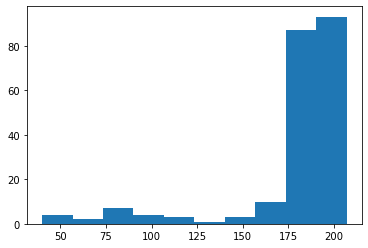

Edge Weight Hist


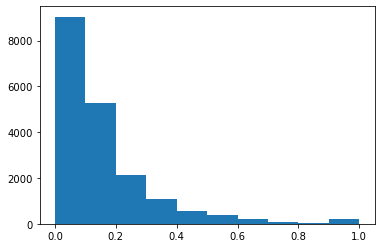

['煎蛋卷', '奶酪', '牛奶', '肉丸', '饼干', '油饼', '蛋卷', '火腿肠', '奶油', '清汤', '火腿', '香肠', '甜点', '巧克力牛奶', '棉花糖']
身体部位
Number of Nodes: 44
Node Degree Hist


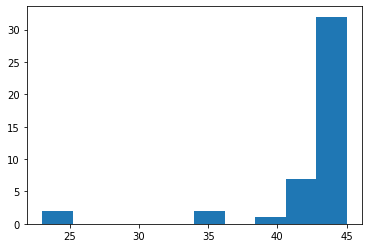

Edge Weight Hist


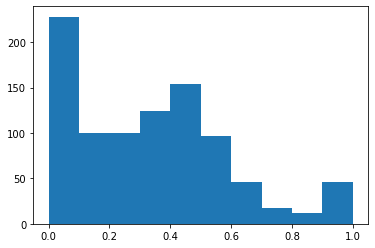

['臀部', '肩膀', '脚趾', '脚背', '嘴唇', '拇指', '膝盖', '大腿', '心脏', '腿', '关节', '手臂', '脚后跟', '血管', '手指']
自然物
Number of Nodes: 36
Node Degree Hist


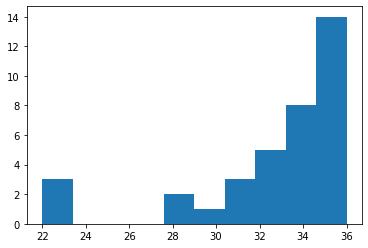

Edge Weight Hist


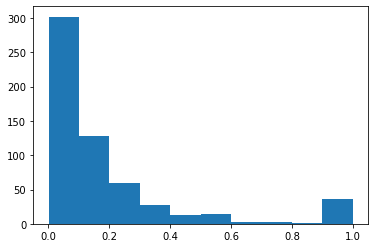

['沟渠', '岩石', '水晶', '宝石', '月亮', '沙坑', '煤田', '大理石', '钻石', '雪花', '煤炭', '流星', '白银', '珍珠', '冰雹']
交通工具
Number of Nodes: 53
Node Degree Hist


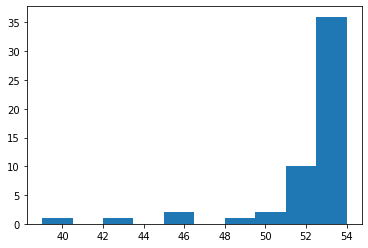

Edge Weight Hist


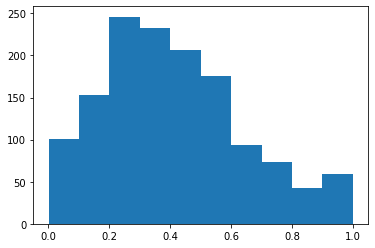

['汽车', '卡车', '吉普车', '赛车', '轿车', '跑车', '车辆', '豪华轿车', '公交车', '摩托车', '电动汽车', '卡丁车', '出租车', '三轮车', '巴士']
植物
Number of Nodes: 211
Node Degree Hist


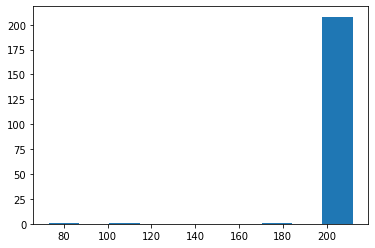

Edge Weight Hist


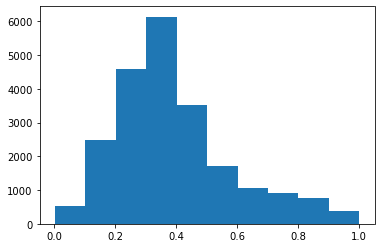

['蕨菜', '青菜', '橄榄', '生菜', '番茄', '卷心菜', '花菜', '大头菜', '西兰花', '蓝莓', '茼蒿', '红薯', '花', '笋', '草']
动物
Number of Nodes: 196
Node Degree Hist


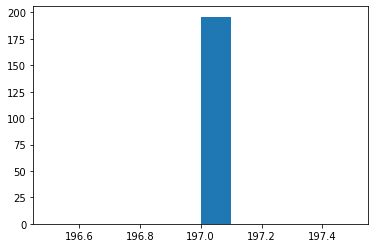

Edge Weight Hist


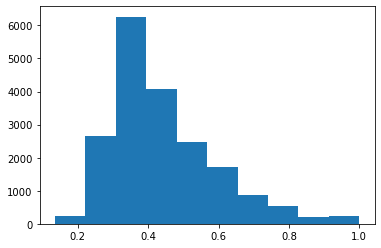

['刺猬', '鲤鱼', '猪', '海豹', '豚鼠', '狐狸', '鲸鱼', '海狮', '松鼠', '狼', '犀牛', '鲶鱼', '美洲狮', '猴子', '老虎']
人造物
Number of Nodes: 656
Node Degree Hist


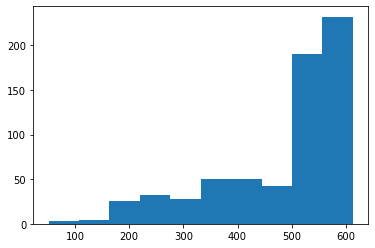

Edge Weight Hist


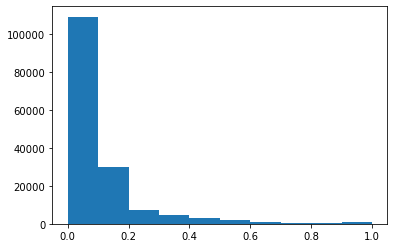

['便盆', '漏斗', '清洁球', '针线篮', '桶', '陀螺', '扫帚', '猫砂', '簸箕', '管道', '储蓄罐', '沙漏', '万花筒', '骨灰盒', '积木']


In [980]:
maincategorys = {'交通工具', '人造物', '动物', '植物', '自然物', '身体部位', '食物'}
for i in maincategorys:
    print(i)
    view = ClusterFilter(G_ConceptNetwork,'maincategory',i,'weight',0,False,'G6')
    cue_words = NodeSampling(view,15,'top')
    print(cue_words)

In [982]:
with open('02_Graph/ConceptNetwork_Complete_CCFD-Similarity-Matrix.json','w+') as f:
    f.write(json.dumps(nx.node_link_data(G_ConceptNetwork), ensure_ascii=False).replace('links','edges'))

In [196]:

# 利用Degree选出重要的节点
selected_nodes = [n for n,v in G_ConceptNetwork.nodes(data=True) if G_ConceptNetwork.degree(n) > 1200]  
G_ = G_ConceptNetwork.subgraph(selected_nodes)

# 利用边的权重筛选出核心子图中最紧密的连接，构成子图
selected_edges = [(u,v,e) for u,v,e in G_.edges(data=True) if e['weight'] > 8]
G_Center = nx.Graph(selected_edges)

# 选出子图中最大的Connected Component，作为试验用的子图
# nx.number_connected_components(G_Center)
largest_cc = max(nx.connected_components(G_Center), key=len)
len(largest_cc)
G_Exp = G_Center.subgraph(largest_cc)

### 计算图指标

In [276]:
# 小世界指数(需要很长时间，跑了三小时还没算出来)
# nx.sigma(G_Exp)

In [224]:
# 计算 loseness centrality
closeness_centrality = nx.closeness_centrality(G_Exp)

# 重映射值域
# closeness_centrality.update((x, translate(y,min(closeness_centrality.values()), max(closeness_centrality.values()), 0, 20 )) for x, y in closeness_centrality.items())

# 写入节点属性
nx.set_node_attributes(G_Exp, closeness_centrality, "closeness_centrality")



G_Exp.nodes["豆腐"]

{'closeness_centrality': 0.21428571428571427,
 'subcategory': '固态干粮',
 'maincategory': '食物'}

### 可视化

In [ ]:
# 利用pyvis进行可视化（需在浏览器中打开）
# nt = net.Network(notebook=True)
# nt.from_nx(T)
# nt.show('nx.html')


# 导出gephi格式
# nx.write_gexf(T, "CCFD_Core.gexf")

## 试验用的概念-特征网络

In [247]:
df_exp = df_complete[df_complete['Concept'].isin(largest_cc)]
df_exp.head()

,Concept,Rel,Feature,Frequency,familiarity,concretness,上级类别,下级类别,coverage
45,安全帽,可以,可以-保护,29.0,8.33,9.0,人造物,工具,0.717619
46,安全帽,可以,可以-保护头,20.0,8.33,9.0,人造物,工具,0.717619
47,安全帽,是,是-帽子,17.0,8.33,9.0,人造物,工具,0.717619
48,安全帽,有,有-带子,16.0,8.33,9.0,人造物,工具,0.717619
49,安全帽,是,是-硬的,14.0,8.33,9.0,人造物,工具,0.717619


In [268]:
# 计算特征线索度
cue_validities = []

for row in df_exp.iterrows():
    cue_validity = row[1]['Frequency'] / sum(list(df_complete[df_complete['Feature']==row[1]['Feature']]['Frequency']))
    cue_validities.append(cue_validity)

df_exp['cue_validity'] = cue_validities
df_exp.head()

<ipython-input-268-82335c6fc863>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp['cue_validity'] = cue_validities


,Concept,Rel,Feature,Frequency,familiarity,concretness,上级类别,下级类别,coverage,cue_validity
45,安全帽,可以,可以-保护,29.0,8.33,9.0,人造物,工具,0.717619,0.041011
46,安全帽,可以,可以-保护头,20.0,8.33,9.0,人造物,工具,0.717619,0.361276
47,安全帽,是,是-帽子,17.0,8.33,9.0,人造物,工具,0.717619,0.129977
48,安全帽,有,有-带子,16.0,8.33,9.0,人造物,工具,0.717619,0.137468
49,安全帽,是,是-硬的,14.0,8.33,9.0,人造物,工具,0.717619,0.019729


In [ ]:
# 保存文件
# df_exp.to_csv("03_Experiment/Concept-Feature-Network_Experiment.csv", index=False)
# df_exp = pd.read_csv("03_Experiment/Concept-Feature-Network_Experiment.csv")

## 模拟患者语义网络

In [283]:
## stimuli

# 手动填写 stimuli

# intial_stimuli = [
#     ['耳朵','手掌', '脚后跟','肩膀','牙齿','鼻子'],
#     ['鸽子','麻雀', '燕子','天鹅','喜鹊','猫头鹰'],
#     ['猴子','狮子', '兔子','老虎','老鼠','奶牛'],
#     ['苹果','香蕉', '葡萄','甘蔗','柑橘','西瓜'],
#     ['萝卜','土豆', '白菜','黄瓜','韭菜','茄子'],
#     ['直升机','火车', '帆船','卡车','轿车','摩托车'],
#     ['茅草屋','人行天桥', '车库','立交桥','高速公路','喷泉'],
#     ['衬衫','毛衣', '夹克','袜子','围巾','裤子'],
#     ['沙发','椅子', '餐桌','书柜','马桶','冰箱'],
#     ['扫帚','雨伞', '剪刀','纱布','拐杖','筷子']
# ]

#检验 stimuli 是否在数据库中
#len(df_rel[df_rel['head']=="脚跟"])

# for cue in cues:
#     if len(df_complete[df_complete['Concept']==cue]) == 0:
#         print(cue)
#     else:
#         print(df_complete[df_complete['Concept']==cue])



# 随机采样生成 stimuli
subcategories = list(df_exp.下级类别.unique())

intial_stimuli = []
for subcategory in subcategories:
    stimuli = list(df_exp[df_exp['下级类别']==subcategory].sort_values(by=['familiarity', 'coverage','concretness'],ascending=False).head(120)["Concept"].unique())
    intial_stimuli.append(stimuli)
    print(stimuli,subcategory)
intial_stimuli = sum(intial_stimuli,[])

['钢笔', '黑板擦', '擀面杖', '缝衣针'] 工具
['衬衫', '夹克', '风衣'] 服饰
['瓜', '番茄', '黄瓜'] 蔬菜
['豆浆', '菠萝汁', '豆奶', '咖啡'] 酒水饮料
['柑橘', '荔枝', '金橘'] 水果
['鸡蛋', '大饼', '米线', '麻花'] 固态干粮
['宝石'] 自然物
['茶壶', '炖锅', '筷子'] 餐具
['弹簧床垫', '毛毯', '床垫', '窗帘'] 家具
['豆豉', '辣椒酱', '醋', '草莓酱'] 调料
['莲花', '菊花', '雏菊', '玫瑰'] 花草
['轿车', '房车', '豪华轿车'] 车
['鲸鱼', '螺蛳', '金鱼'] 水生动物
['刀', '飞镖', '棍棒'] 武器
['电冰箱'] 电器
['鸽子', '鹅', '金丝雀'] 鸟
['飞机', '飞碟', '飞艇'] 飞机
['飞盘'] 玩具
['蟒蛇', '狗'] 陆生动物
['豪华客轮'] 船
['桦木', '黄金树'] 树木
['火腿', '腊肠', '腊肉'] 肉食
['胶囊'] 医疗用品
['毛毛虫', '昆虫'] 昆虫
['篮球'] 运动器材


In [589]:
## 选择提示词相关的所有语义特征，作为个人语义网络数据
df_complete_initial = df_exp[df_exp['Concept'].isin(intial_stimuli)]

# 复制一份，默认所有概念-特征对的激活状态为 0
df_compare_initial = df_complete_initial.copy()
df_compare_initial['activation'] = 0

# 【模拟】患者的语义特征分析数据
df_pwa_initial = Sample_PWA(df_complete_initial, 0.5, 'activation')

# 将与患者数据对应的概念-语义特征对的激活状态设为 1
for row in df_pwa_initial.iterrows():
    row_index = df_compare_initial.loc[(df_compare_initial['Concept'] == row[1]['Concept']) & (df_compare_initial['Feature'] == row[1]['Feature'])].index
    df_compare_initial['activation'][row_index]=1

df_compare_initial.head()
# df_compare_initial.to_csv('04_Compare/Concept-Feature-Network_compare_initial.csv', index=False)


<ipython-input-589-855e1395782a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compare_initial['activation'][row_index]=1


,Concept,Rel,Feature,Frequency,familiarity,concretness,上级类别,下级类别,coverage,cue_validity,activation
1724,宝石,是,是-石头,11.0,8.33,9.0,自然物,自然物,0.721707,0.081093,0
1725,宝石,是,是-贵的,10.0,8.33,9.0,自然物,自然物,0.721707,0.035495,1
1726,宝石,是,是-矿物,10.0,8.33,9.0,自然物,自然物,0.721707,0.178721,0
1727,宝石,有,有-多种颜色,9.0,8.33,9.0,自然物,自然物,0.721707,0.003912,0
1728,宝石,是,是-亮的,8.0,8.33,9.0,自然物,自然物,0.721707,0.056352,1


In [591]:
List_Semantic_Feature(df_compare_initial,'宝石')

,Feature,cue_validity,activation
1756,是-菱形的,1.000000,1
1760,需要-发掘,1.000000,1
1765,是-闪光的,1.000000,0
1774,有-高硬度,1.000000,0
1775,有-珊瑚,1.000000,0
1730,是-闪亮的,0.777778,1
1755,可以-升值,0.600000,1
1767,是-稀有的,0.500000,1
1772,需要-抛光,0.500000,1
1749,有-光泽,0.445511,1


In [604]:
Extract_Associate_SemanticFeature(df_compare_initial, 'Concept', 'Feature', '轿车', '房车')

{'像-面包车',
 '其他-交通',
 '可以-乘坐',
 '可以-买卖',
 '可以-行驶',
 '是-工具',
 '是-车',
 '有-发动机',
 '有-座位',
 '有-方向盘',
 '有-窗户',
 '有-车厢',
 '有-轮子',
 '有-门',
 '需要-保养',
 '需要-加油',
 '需要-司机',
 '需要-检查',
 '需要-汽油',
 '需要-油',
 '需要-清洗',
 '需要-电',
 '需要-维护',
 '需要-驾驶'}

In [471]:
# 从患者数据中提取连接强度
df_pwa_ConceptNetwork = Extract_Association_Network(df_pwa_initial, 'Concept', 'Feature', 0)

# 加入到测试网络数据中
for u, v, e in G_Exp.edges(data=True):
    row = df_pwa_ConceptNetwork[(df_pwa_ConceptNetwork['Source']==u)&(df_pwa_ConceptNetwork['Target']==v)]
    if(len(df_pwa_ConceptNetwork[(df_pwa_ConceptNetwork['Source']==u)&(df_pwa_ConceptNetwork['Target']==v)]!=None)!=0):
        e['initial_weight'] = int(row['Strength'])
    else:
        e['initial_weight'] = 0

In [476]:
df_pwa_initial.head()

,Concept,Rel,Feature,Frequency,familiarity,concretness,上级类别,下级类别,coverage,cue_validity,activation
1725,宝石,是,是-贵的,10.0,8.33,9.0,自然物,自然物,0.721707,0.035495,1
1728,宝石,是,是-亮的,8.0,8.33,9.0,自然物,自然物,0.721707,0.056352,1
1729,宝石,是,是-硬的,8.0,8.33,9.0,自然物,自然物,0.721707,0.011274,1
1730,宝石,是,是-闪亮的,7.0,8.33,9.0,自然物,自然物,0.721707,0.777778,1
1732,宝石,像,像-石头,7.0,8.33,9.0,自然物,自然物,0.721707,0.024284,1


TypeError: cannot convert the series to <class 'int'>

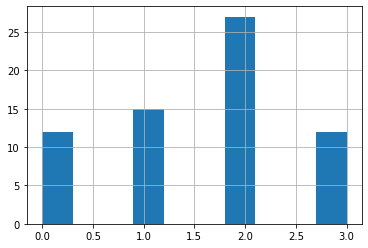

In [509]:
# 由cue_validity的和决定节点的命名情况
# 0,1,2,3 分别代表三次测试中成功命名的次数

def Picture_Naming(x):
    if(x>4.5):
        return 3
    elif(x>2):
        return 2
    elif(x>1.5):
        return 1
    else:
        return 0

df_pwa_initial_PictureNaming = df_pwa_initial.groupby('Concept').sum().sort_values(by='cue_validity',ascending=False)
df_pwa_initial_PictureNaming['picture_naming'] = df_pwa_initial_PictureNaming['cue_validity'].apply(lambda x: picture_naming(x))
df_pwa_initial_PictureNaming['picture_naming'].hist()


In [510]:
int(df_pwa_initial_PictureNaming[df_pwa_initial_PictureNaming.index=='飞镖']['picture_naming'])

3

In [592]:
# 给 G_Exp 加入模拟的图片命名数据

for node in G_Exp.nodes:
    picture_naming_result = df_pwa_initial_PictureNaming[df_pwa_initial_PictureNaming.index==node]['picture_naming']
    if(len(picture_naming_result)==1):
        G_Exp.nodes[node]['semantic_feature'] = 1
        G_Exp.nodes[node]['picture_naming'] = int(picture_naming_result)
    else:
        G_Exp.nodes[node]['semantic_feature'] = 0
        G_Exp.nodes[node]['picture_naming'] = random.randint(0,3)

# G_Exp.nodes['胶水']

In [584]:
# 查询某个节点属性的所有可能情况
# query a graph for all the possible attributes that might have been applied across the various nodes
# set(np.array([G_Exp.nodes[n].keys() for n in G_Exp.nodes]).flatten())
# set(np.array([G_Exp.nodes[n]['maincategory'] for n in G_Exp.nodes]).flatten())

{'交通工具', '人造物', '动物', '植物', '自然物', '食物'}

In [593]:
## 可视化

# 保存为d3可用的json文件
with open('04_Compare/ConceptNetwork_Experiment.json','w+') as f:
    f.write(json.dumps(nx.node_link_data(G_Exp), ensure_ascii=False))


# 导出gephi格式
# nx.write_gexf(G_Exp, "04_Compare/ConceptNetwork_Experiment.gexf")

In [596]:
## subgraph query
selection = ['糕点', '可可巧克力', '醋', '豆浆', '豆奶', '可口可乐', '比萨', '筷子', '鸡肉', '棉花糖']
G_selection = G_Exp.subgraph(selection)

In [602]:
with open('04_Compare/ConceptNetwork_Experiment_Selection.json','w+') as f:
    f.write(json.dumps(nx.node_link_data(G_selection), ensure_ascii=False))

## 从患者网络中抽取关联网络

In [174]:
df_impair_individual_concept_network = Extract_Association_Network(df_impair_individual, 'Concept', 'Feature', 5)
df_impair_individual_concept_network.head()

,Source,Target,Strength
0,安全带,手机,6
1,白糖,橙汁,9
2,白糖,大饼,6
3,白糖,豆豉,9
4,白糖,豆浆,8


In [176]:
df_impair_individual_feature_network = Extract_Association_Network(df_impair_individual, 'Feature', 'Concept', 5)
df_impair_individual_feature_network.head()

In [ ]:
df_impair_individual_feature_network.to_csv('01_Processed Data/SemanticFeature_Link_PWA-Minor.csv')

## Node_Link CSV to Json (NodeTrix / G6)

In [ ]:
# Nodetrix json format

# "nodes":[
#     {"name":"Myriel","group":1},
#         ...]
# "links":[
#     {"source":1,"target":0,"value":1},
#         ...]

In [ ]:
df_node = pd.read_csv('00_Raw Data/CCFD_concept_info.csv')
df_node.head()

,Id,Label,concept,familiarity,concretness,上级类别,superior category,下级类别,subcategory,coverage
0,安全带,安全带,Safety belt,9.00,9.0,人造物,artificial object,工具,tool,0.851345
1,安全帽,安全帽,Safety hat,8.33,9.0,人造物,artificial object,工具,tool,0.717619
2,安慰奶嘴,安慰奶嘴,pacifier,9.00,9.0,人造物,artificial object,餐具,tableware,0.663182
3,鹌鹑,鹌鹑,quail,7.00,9.0,动物,animal,鸟,bird,0.731581
4,鹌鹑蛋,鹌鹑蛋,Quail egg,9.00,9.0,食物,food,固态干粮,solid food,0.741644


In [ ]:
df_concept_network = pd.read_csv('02_Graph/Concept_Link.csv')
df_concept_network.head()

,Source,Target,Strength
0,安全带,安全帽,7
1,安全带,按键,5
2,安全带,按摩器,2
3,安全带,按钮,6
4,安全带,八哥,1


In [ ]:
data = Node_Link_CSV2Json(df_impair_individual_concept_network,df_node,"Label","下级类别", "edges", "name")
%%time

nodes: 276
links: 5201


UsageError: Line magic function `%%time` not found.


In [ ]:
data = Node_Link_CSV2Json(test_2,df_node,"Feature","Rel", "edges", "name")
%%time

nodes: 82
links: 577


In [ ]:
with open("04_G6/CCFD_G6_Concept_PWA-Minor.json_276", "w") as f: 
    json.dump(data, f, ensure_ascii=False)

NodeView((1, 2, 3))

In [ ]:
def read_json_file(filename, typeName):
    with open(filename) as f:
        G = nx.Graph()
        data = json.load(f)
        links = data['edges']
        edges = []
        for i in links:
            edge = []
            edge.append(data['nodes'][links[i['id']]['source']]['label'])
            edge.append(data['nodes'][links[i['id']]['target']]['label'])
            edges.append(tuple(edge))
        G.add_edges_from(edges)
        for i in G.nodes:
            G.nodes[i]['type']=typeName
            G.nodes[i]['activation_status']=0
    return G